<a href="https://www.kaggle.com/yousseftaoudi/football-match-prediction-eda?scriptVersionId=88570513" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

df = pd.read_csv("../input/football-match-probability-prediction/train.csv")
display(df.columns)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Index(['id', 'target', 'home_team_name', 'away_team_name', 'match_date',
       'league_name', 'league_id', 'is_cup', 'home_team_coach_id',
       'away_team_coach_id',
       ...
       'away_team_history_league_id_1', 'away_team_history_league_id_2',
       'away_team_history_league_id_3', 'away_team_history_league_id_4',
       'away_team_history_league_id_5', 'away_team_history_league_id_6',
       'away_team_history_league_id_7', 'away_team_history_league_id_8',
       'away_team_history_league_id_9', 'away_team_history_league_id_10'],
      dtype='object', length=190)

## Exploring Team Performances (Home & Away games + cup games)

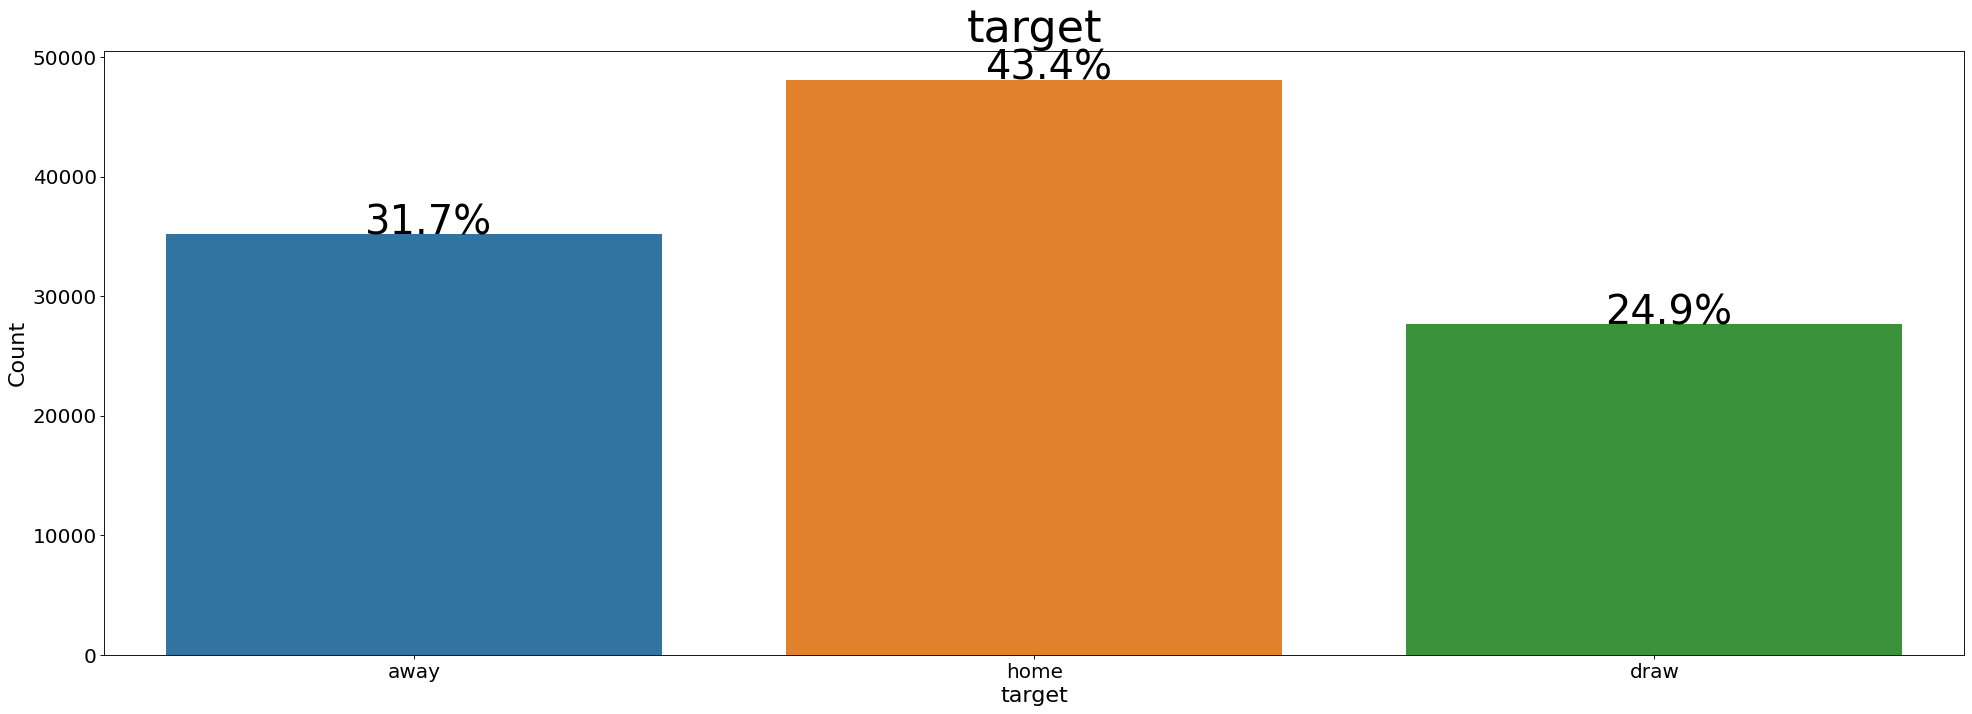

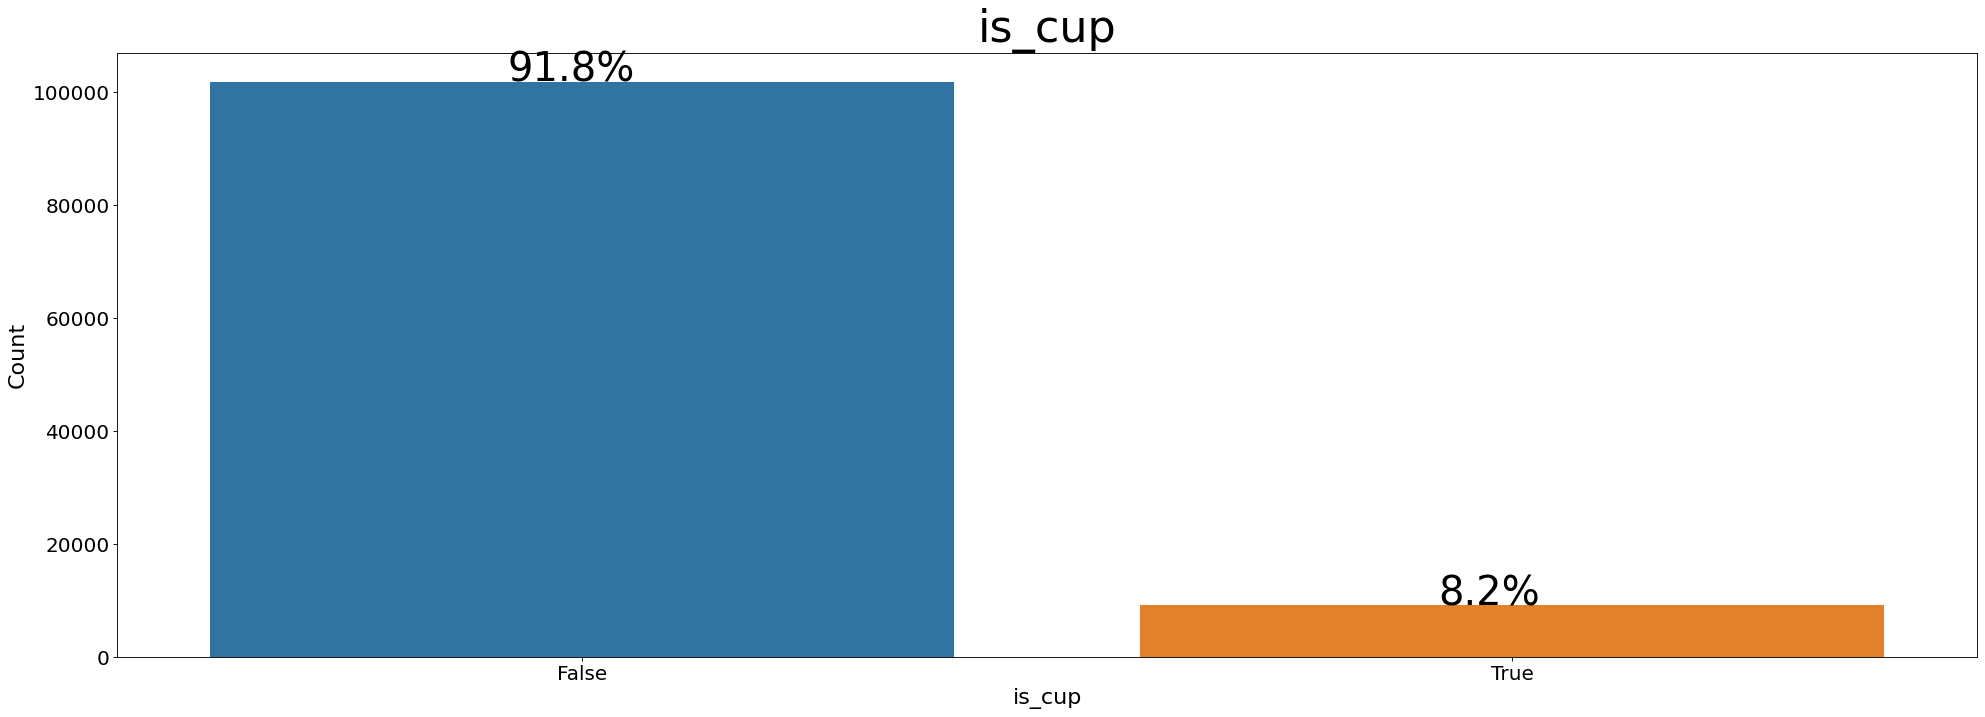

In [2]:
import seaborn as sns
from matplotlib.pyplot import figure


def without_hue(ax, feature,shift=0.08):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - shift
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 36)


features = ['target','is_cup']
sns.color_palette("crest", as_cmap=True)

for col in features:
    figure(figsize=(30, 10), dpi=80)
    ax = sns.countplot(x = df[col])
    plt.title(col, fontsize=40)
    ax.set_xlabel(col, fontsize=20)
    ax.set_ylabel('Count',fontsize=20)
    without_hue(ax,df[col])
    ax.tick_params(axis='both', which='major', labelsize=18)
    plt.show()

    


target - The target is characterized as the outcome of a match. 'Home' means that the home team won, 'Away' means that the away team won and 'Draw' means that the game resulted in a draw. The data is fairly balanced with 'Home' making up 41% of the targets. This does make sense as the home team is generally seen as having an advantage due to familiarity with the pitch and support from fans during the game.

is_cup - The vast majority of games are not cup games. One idea could be to create a seperate model for cup games as the patterns between cup and league game may differ, especially for cup games that play with the home advantage rules.

The win/draw/loss rates don't change very much across league, cup and frienly matches. The only noticable difference is that cup games have a bit more away wins, friendly games have more home wins and league games have more draws.

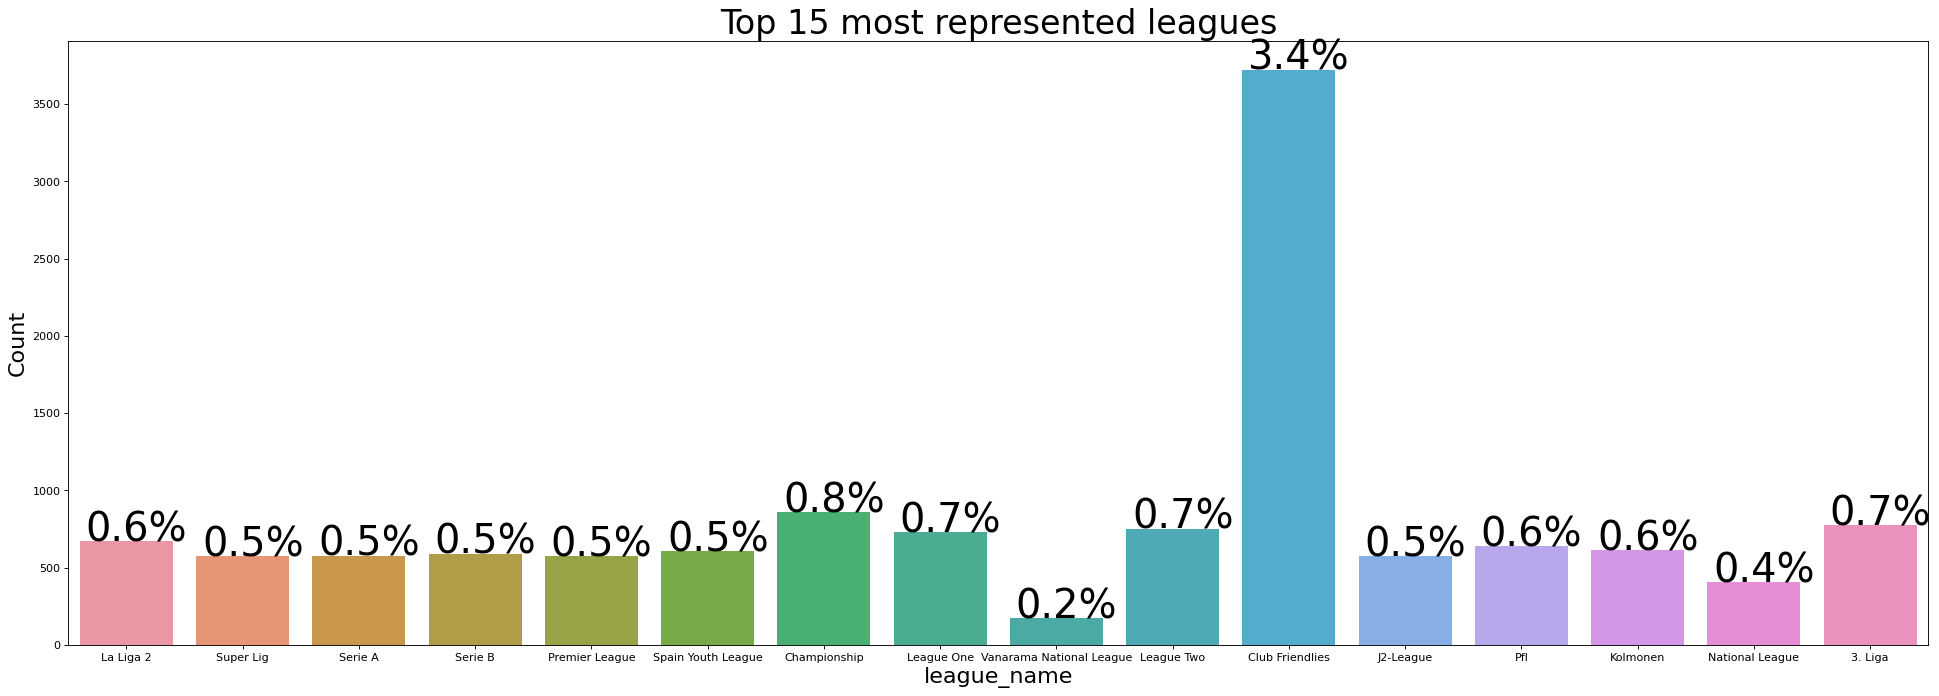

In [3]:
figure(figsize=(30, 10), dpi=80)
n = 15
sns.color_palette("crest", as_cmap=True)

col = 'league_name'
leagues = df['league_id'].value_counts()[:n].index.tolist()
ax = sns.countplot(x = df[df['league_id'].isin(leagues)][col])
plt.title("Top 15 most represented leagues",fontsize=30)
ax.set_xlabel(col, fontsize=20)
ax.set_ylabel('Count',fontsize=20)
without_hue(ax,df['league_id'],shift=0.35)

plt.show()

The distribution of leagues is fairly even with the small exception of "Club Friendlies". One idea could be to filter out all club friendlies or add them as a seperate feature similar to is_cup since many teams don't field strong XIs for such games. Note that the plot only displays the top 15 represented leagues which only make up a small part of the data.

<Figure size 2400x800 with 0 Axes>

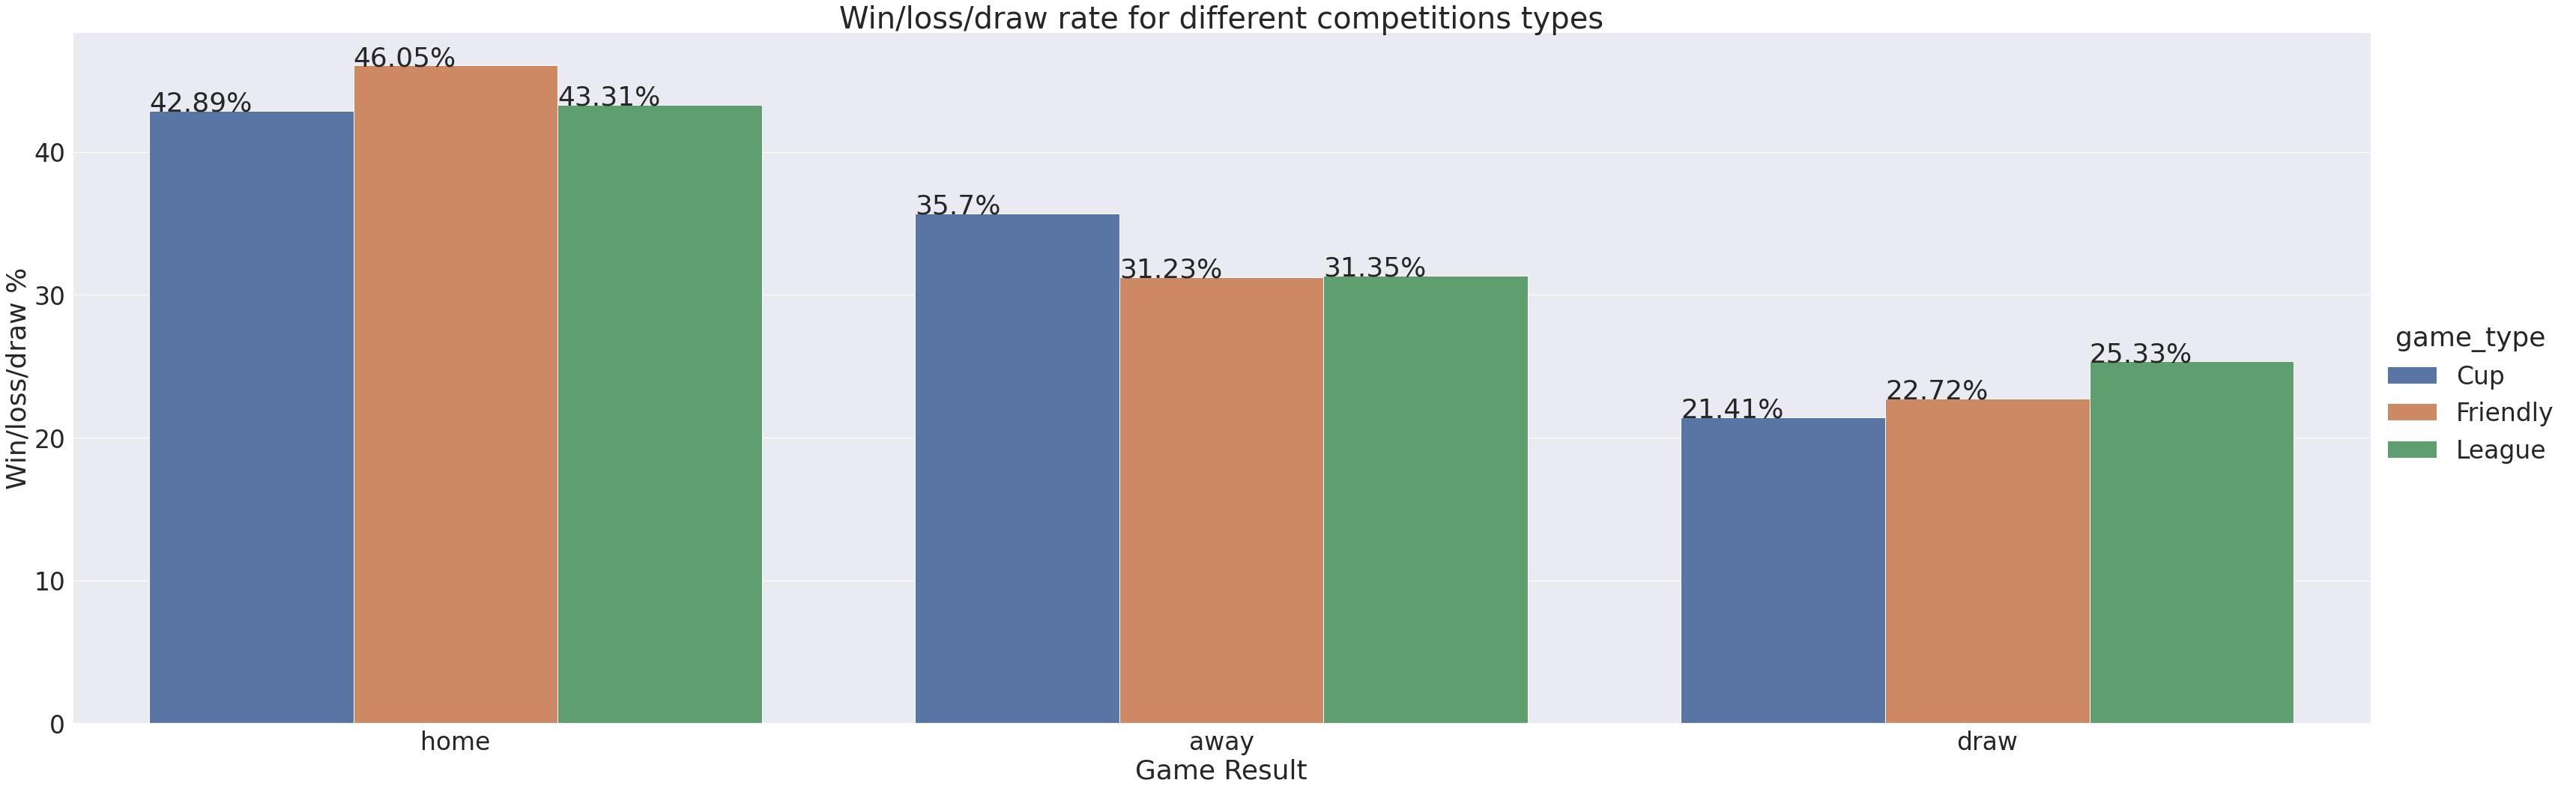

In [4]:
import seaborn as sns
from matplotlib.pyplot import figure


    

df2 = df.copy(deep=True)
df2.loc[df2['is_cup'] == False,'game_type'] = 'League'
df2.loc[df2['is_cup'] == True,'game_type'] = 'Cup'
df2.loc[df2['league_name'] == 'Club Friendlies','game_type'] = 'Friendly'

df1 = df2.groupby('game_type')['target'].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

features = ['target','game_type']
sns.color_palette("crest", as_cmap=True)
figure(figsize=(30, 10), dpi=80)
sns.set(font_scale=3)  # crazy big

g = sns.catplot(x="target",y='percent',hue='game_type',kind='bar',data=df1,height=15,aspect=3)
plt.title("Win/loss/draw rate for different competitions types", fontsize=40)
g.set_axis_labels("Game Result","Win/loss/draw %")
for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
plt.show()




<Figure size 2160x720 with 0 Axes>

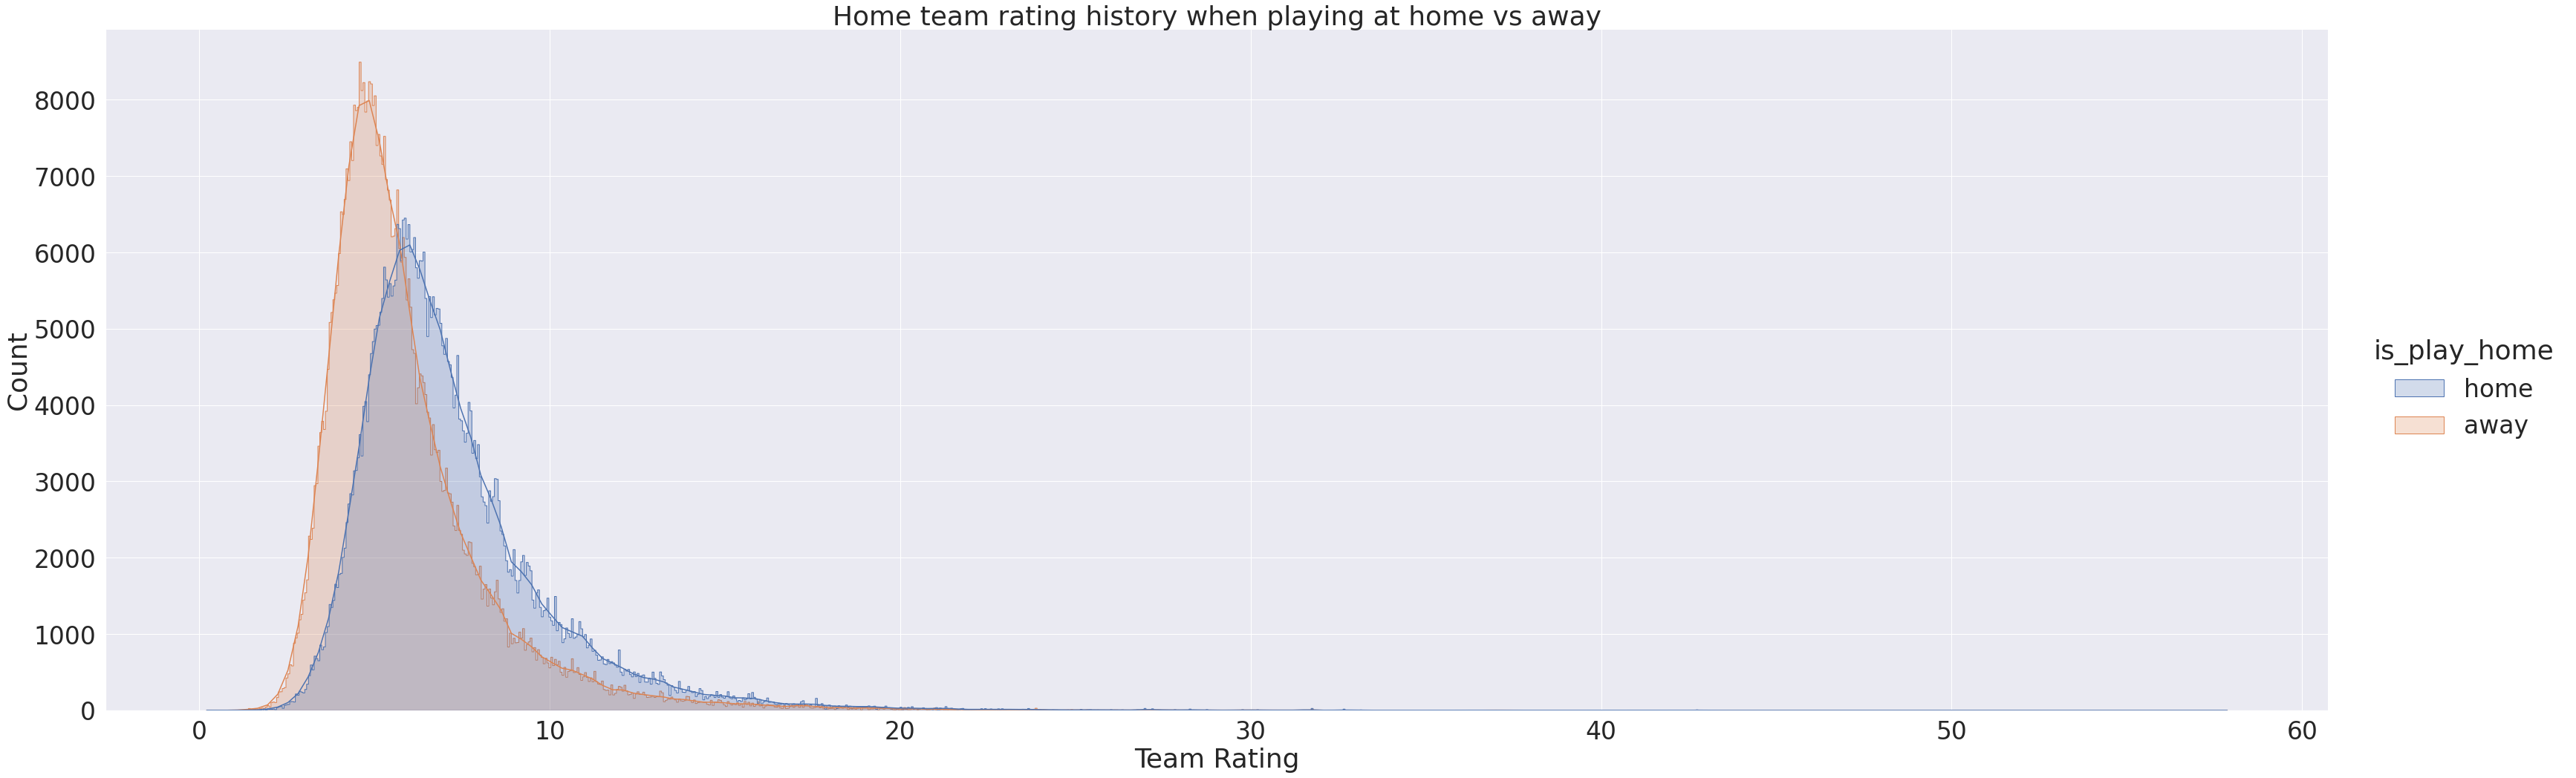

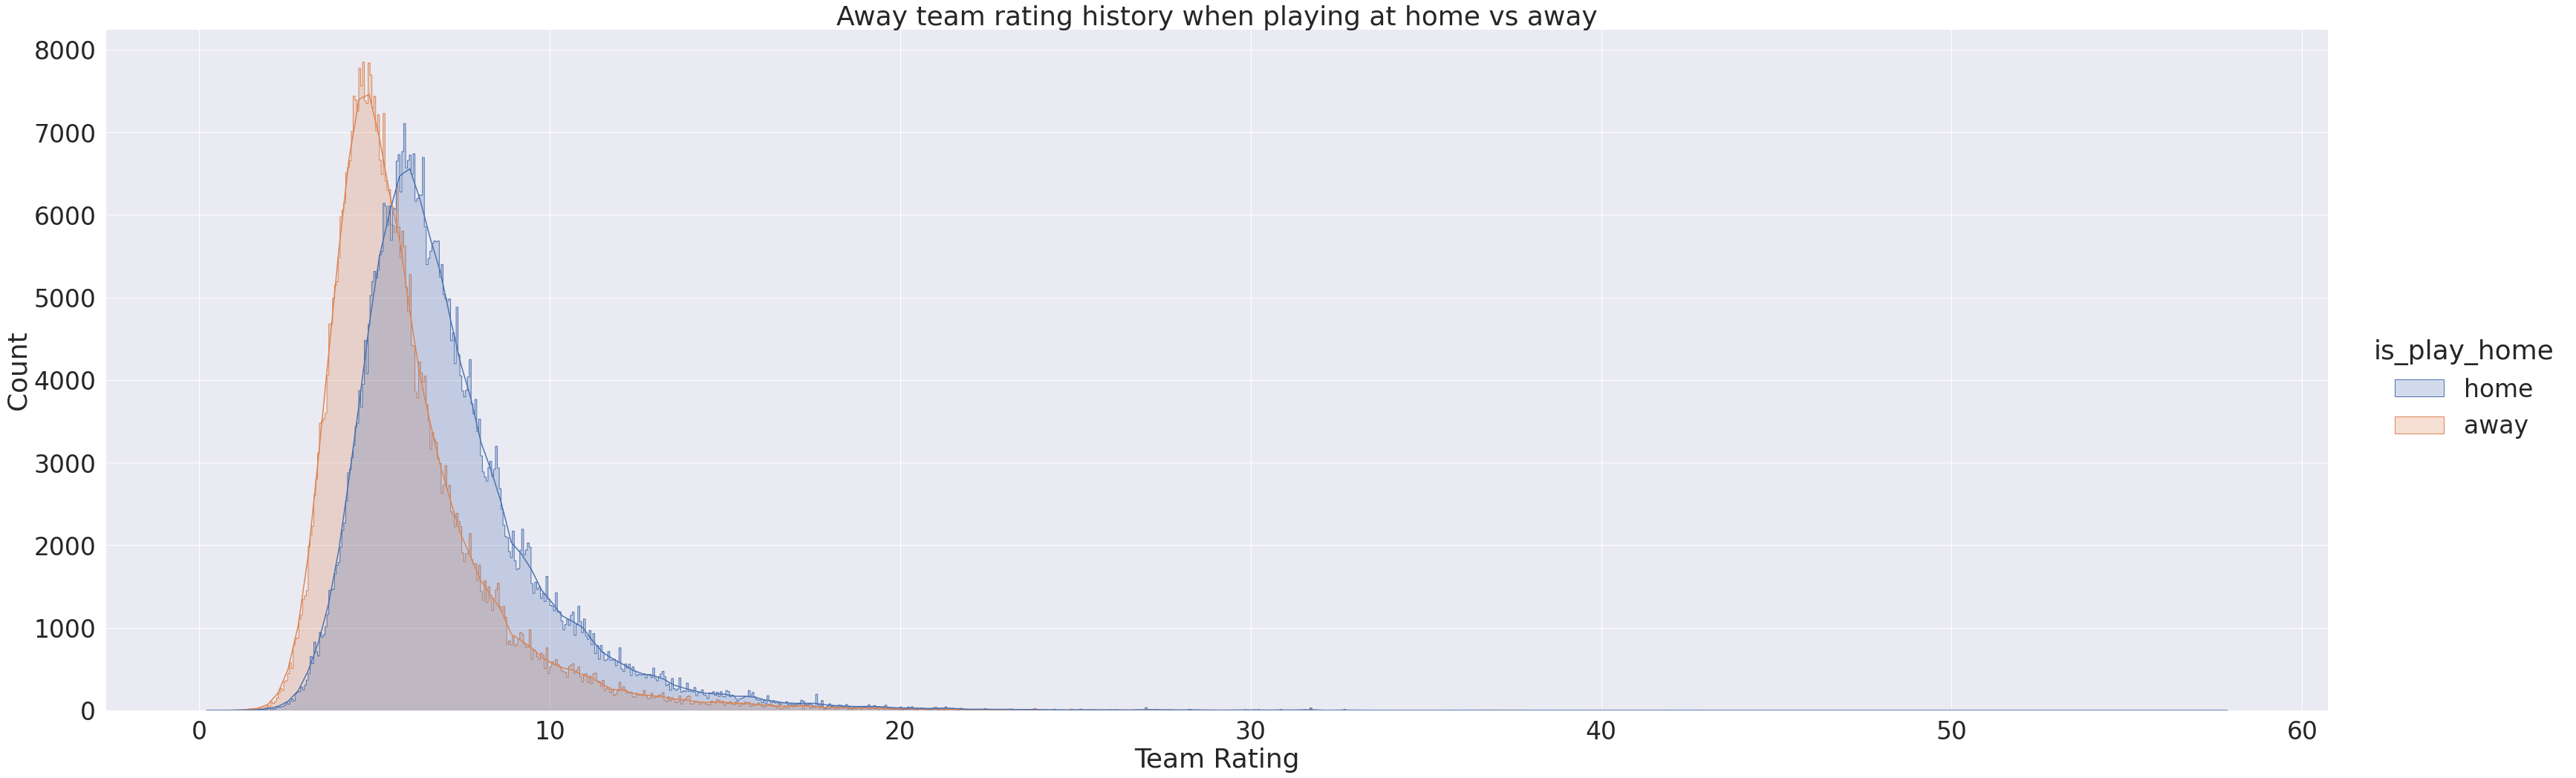

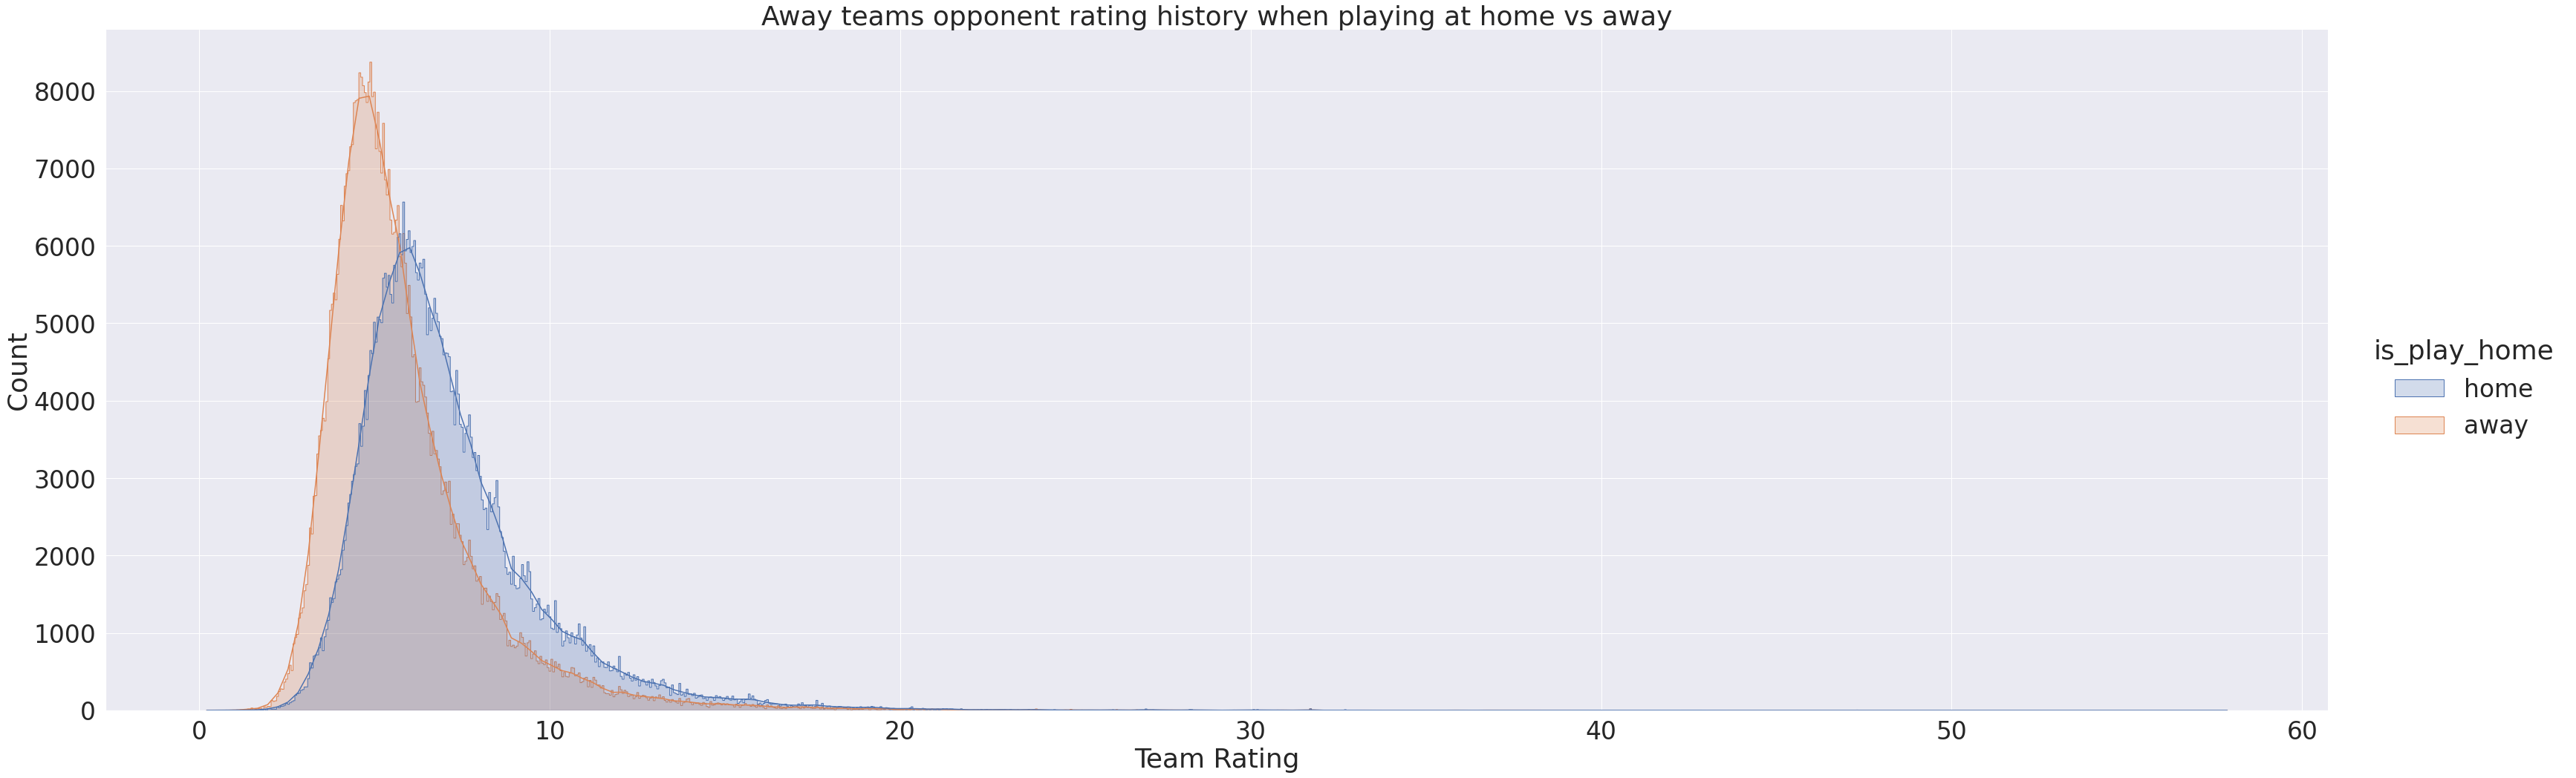

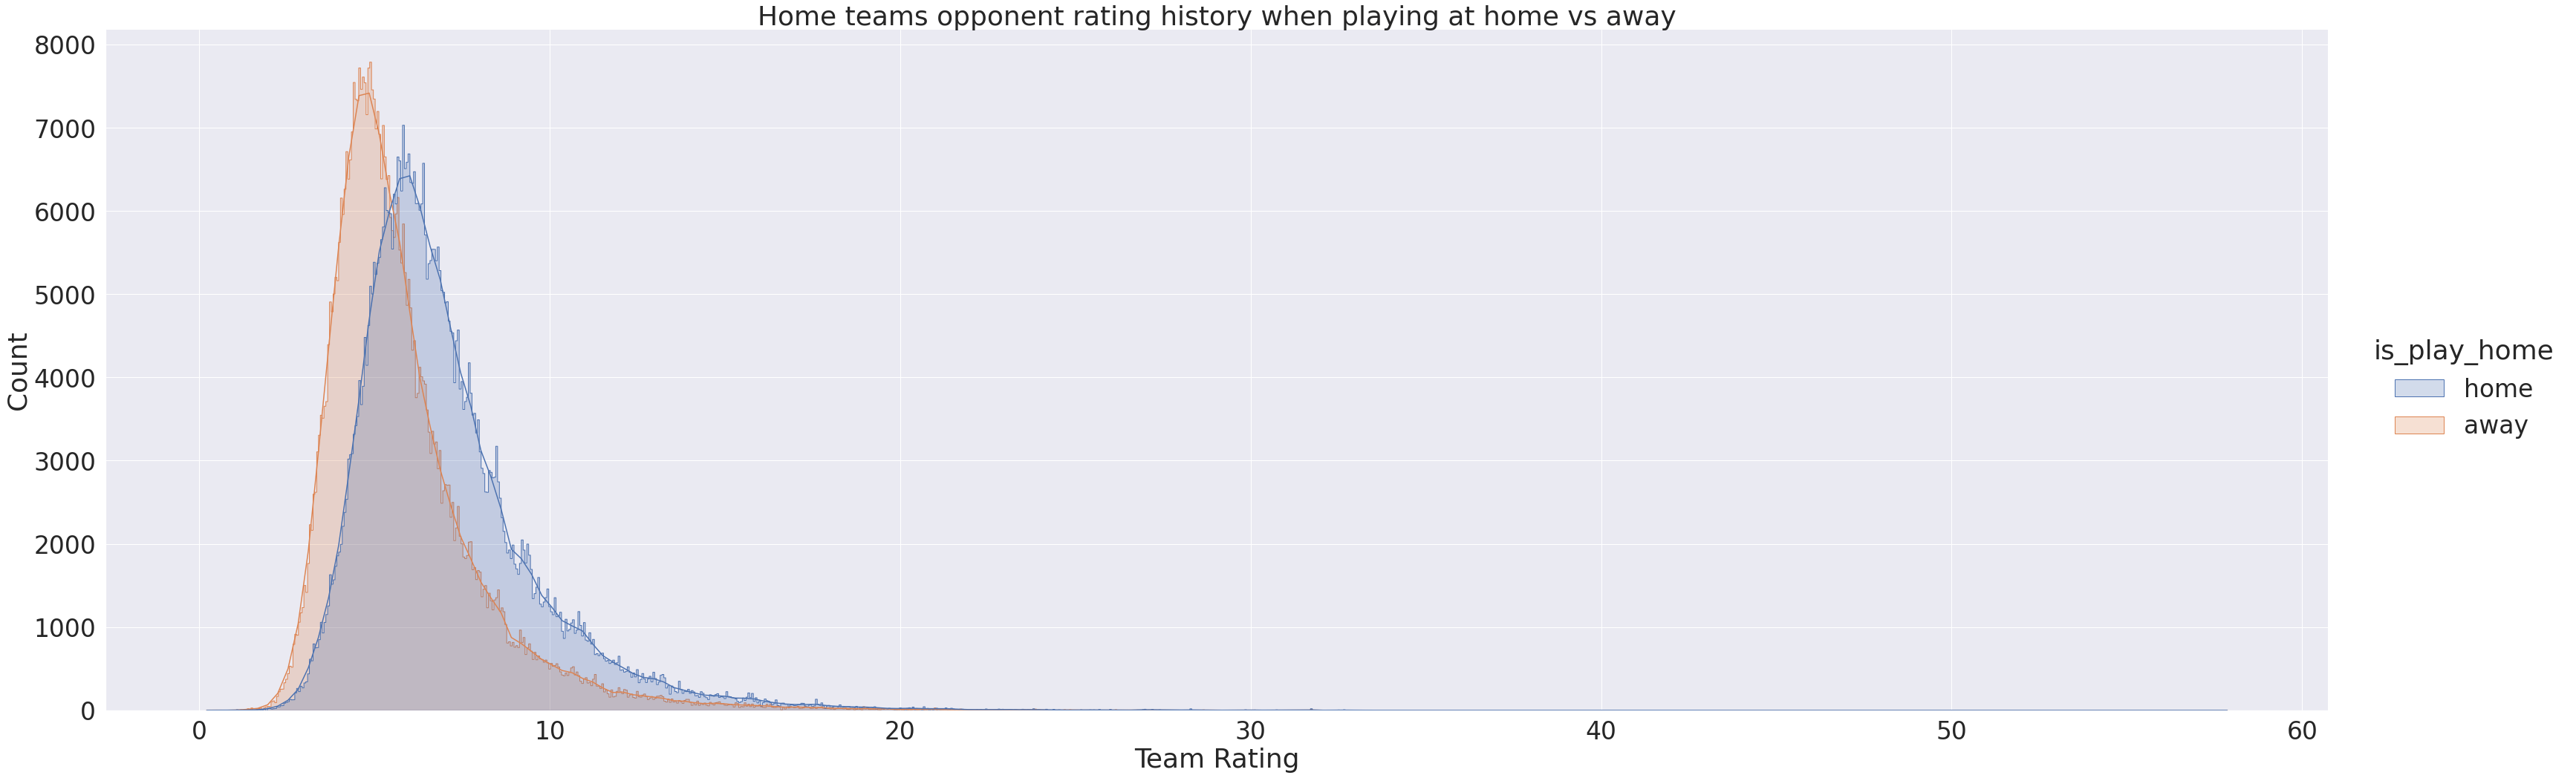

In [5]:
s = 'away_team_history_rating_'
s2 = 'home_team_history_rating_'
s3 = 'away_team_history_opponent_rating_'
s4 = 'home_team_history_opponent_rating_'
s_id = 'away_team_history_league_id'
s_id = 'home_team_history_league_id'

p = "away_team_history_is_play_home_"
p2 = "home_team_history_is_play_home_"
p3 = "away_team_opponent_history_is_play_home_"
p4 = "home_team_opponent_history_is_play_home_"

column_names = ["date"]
new_df = pd.DataFrame(columns = column_names)

history_df = df.loc[:, df.columns.str.contains(p)|df.columns.str.contains(p2)\
                    |df.columns.str.contains(s)|df.columns.str.contains(s2)|df.columns.str.contains(s3)|df.columns.str.contains(s4)|(df.columns == 'id')|(df.columns=='match_date')]
history_df = pd.wide_to_long(history_df, stubnames=[s,s2,s3,s4,p,p2,p3,p4], i="id",j='i')


style.use(style='seaborn')
plt.figure(figsize=(30,10))


history_df.loc[history_df[p2]==0.0,p4] = 'home'
history_df.loc[history_df[p2]==1.0,p4] = 'away'
history_df.loc[history_df[p]==0.0,p3] = 'home'
history_df.loc[history_df[p]==1.0,p3] = 'away'


history_df.loc[history_df[p2]==0.0,p2] = 'away'
history_df.loc[history_df[p2]==1.0,p2] = 'home'
history_df.loc[history_df[p]==0.0,p] = 'away'
history_df.loc[history_df[p]==1.0,p] = 'home'

order = ['home','away']

sns.set(font_scale=3)  # crazy big

history_df = history_df.rename({p2:'is_play_home'}, axis='columns')
ax = sns.displot(history_df,x='home_team_history_rating_',fill=True,element="step",kde=True,hue='is_play_home',height=15,aspect=3,hue_order=order)
ax.set_axis_labels("Team Rating","Count")
plt.title("Home team rating history when playing at home vs away")
plt.show()
history_df = history_df.rename({'is_play_home':p2}, axis='columns')

history_df = history_df.rename({p:'is_play_home'}, axis='columns')
ax = sns.displot(history_df,x='away_team_history_rating_',fill=True,element="step",kde=True,hue='is_play_home',height=15,aspect=3,hue_order=order)
ax.set_axis_labels("Team Rating","Count")
plt.title("Away team rating history when playing at home vs away")
plt.show()
history_df = history_df.rename({'is_play_home':p}, axis='columns')

history_df = history_df.rename({p3:'is_play_home'}, axis='columns')
ax = sns.displot(history_df,x='away_team_history_opponent_rating_',fill=True,element="step",kde=True,hue='is_play_home',height=15,aspect=3,hue_order=order)
ax.set_axis_labels("Team Rating","Count")
plt.title("Away teams opponent rating history when playing at home vs away")
plt.show()
history_df = history_df.rename({'is_play_home':p3}, axis='columns')

history_df = history_df.rename({p4:'is_play_home'}, axis='columns')
ax = sns.displot(history_df,x='home_team_history_opponent_rating_',fill=True,element="step",kde=True,hue='is_play_home',height=15,aspect=3,hue_order=order)
ax.set_axis_labels("Team Rating","Count")
plt.title("Home teams opponent rating history when playing at home vs away")
plt.show()
history_df = history_df.rename({'is_play_home':p4}, axis='columns')

By stacking and visualizing the history ratings over home and away games, we can clearly see that match ratings are generally higher when playing at home.

## Match dates, match date history and seasonality

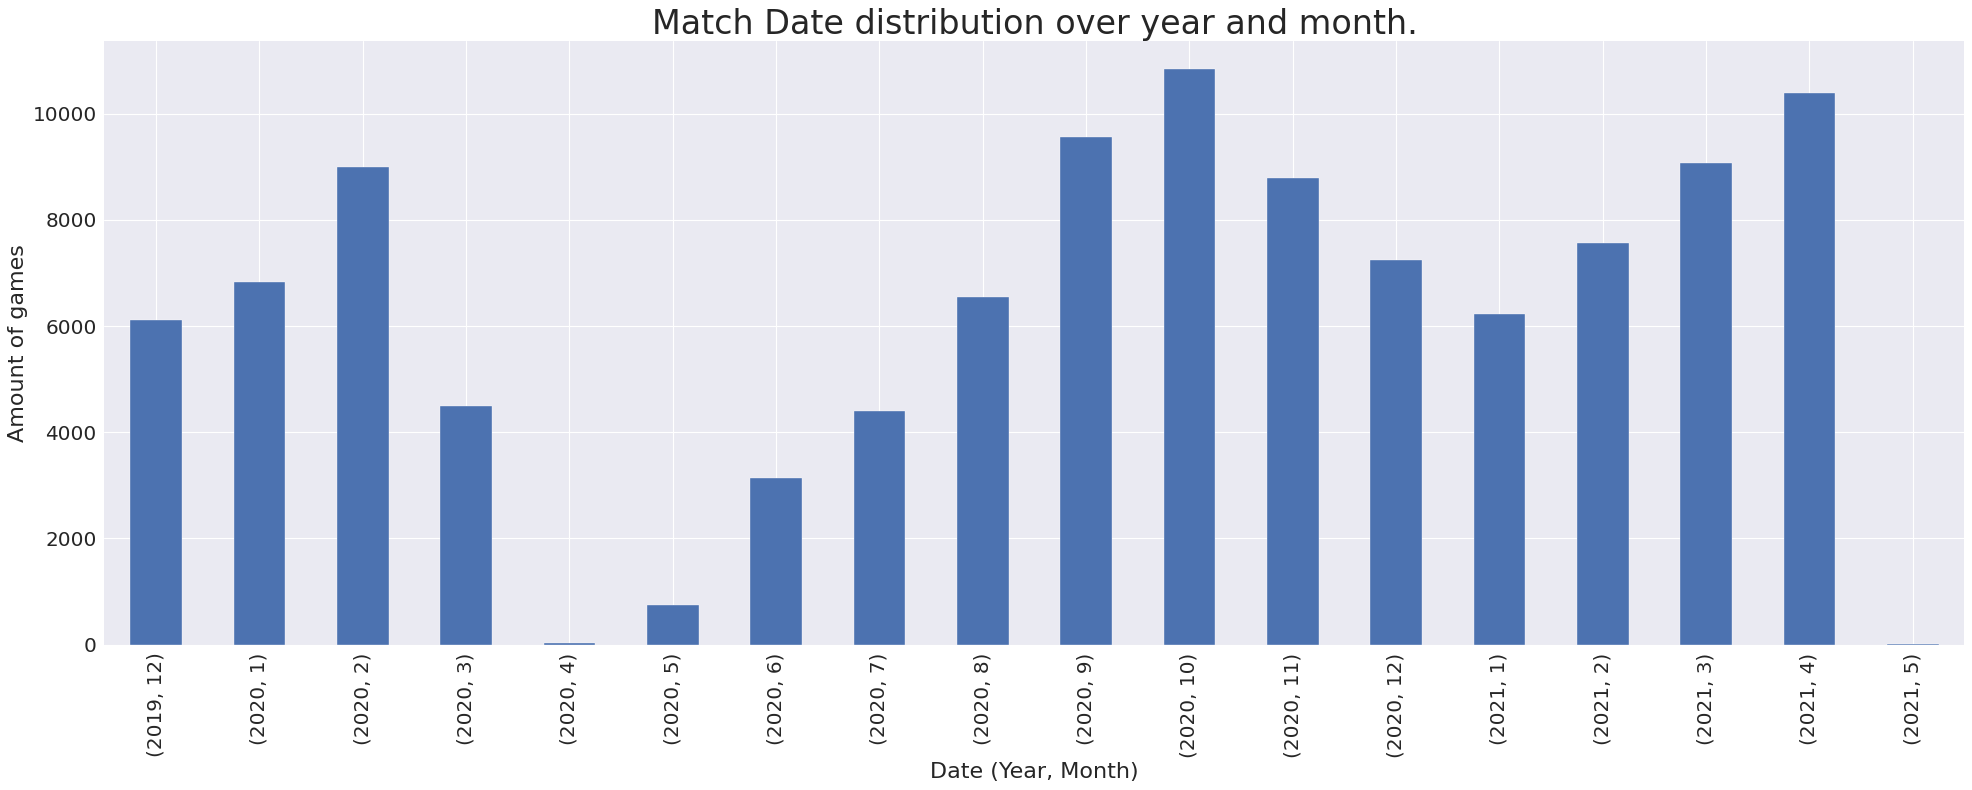

In [6]:

df['date'] = pd.to_datetime(df['match_date'], errors='coerce')

figure(figsize=(30, 10), dpi=80)
style.use(style='seaborn')
ax = df.groupby([df["date"].dt.year, df["date"].dt.month])['date'].count().plot(kind="bar", x='Match Date', y='Count')
ax.set_title("Match Date distribution over year and month.",fontsize=30)
ax.set_xlabel("Date (Year, Month)",fontsize=20)
ax.set_ylabel("Amount of games",fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)


All games were played during the 2019/20 and 2020/21 seasons. This might cause an issue since many games might have been played without fans due to COVID19, which football fans know is a big disadvantage for the home teams. The advantage of having lots of data for only recent seasons is that the football that was played during this time should be fairly similar to the football that is played today in terms of tactics and playstyles.

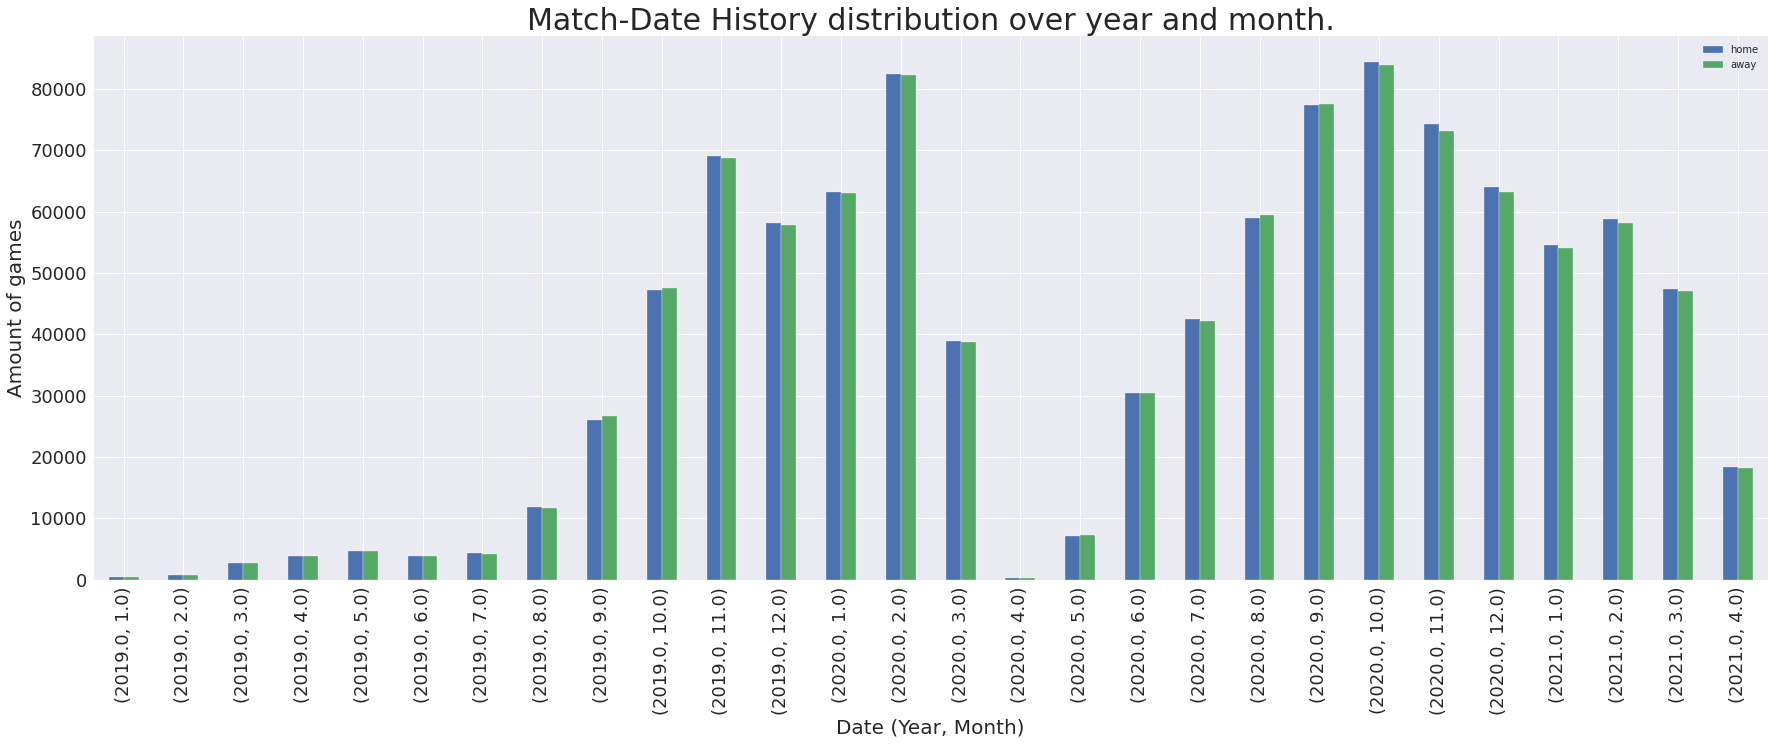

In [7]:
s = 'away_team_history_match_date_'
s2 = 'home_team_history_match_date_'
s_id = 'away_team_history_league_id'
s_id = 'home_team_history_league_id'

column_names = ["date"]
new_df = pd.DataFrame(columns = column_names)

history_df = df.loc[:, df.columns.str.contains(s)| df.columns.str.contains(s2)|(df.columns == 'id')]
history_df = pd.wide_to_long(history_df, stubnames=[s,s2], i="id",j='i')

history_df['home'] = pd.to_datetime(history_df['home_team_history_match_date_'], errors='coerce')
history_df['away'] = pd.to_datetime(history_df['away_team_history_match_date_'], errors='coerce')

home_count = history_df.groupby([history_df["home"].dt.year, history_df["home"].dt.month])['home'].count()
away_count = history_df.groupby([history_df["away"].dt.year, history_df["away"].dt.month])['away'].count()


res = pd.concat([home_count, away_count], axis=1)


style.use(style='seaborn')
ax = res.plot(kind="bar",figsize=(30, 10))
ax.set_title("Match-Date History distribution over year and month.",fontsize=30)
ax.set_xlabel("Date (Year, Month)",fontsize=20)
ax.set_ylabel("Amount of games",fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.show()



The game history naturally spans a bit further back than the match-date feature.